### Snapshot Ensemble

In [9]:
import json
import numpy as np
import sklearn.metrics as metrics
import argparse

import keras.utils.np_utils as kutils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import os
import tensorflow

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, Xception, InceptionResNetV2, NASNetMobile, MobileNet, InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten, Conv2D, Dropout, Activation
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from keras.utils.vis_utils import plot_model



In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15548737292298034507
]


## Snapshot Ensemble Callback Definition

In [ ]:
import numpy as np
import os

import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import Callback

class SnapshotModelCheckpoint(Callback):
    """Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
        fn_prefix: prefix for the filename of the weights.
    """

    def __init__(self, nb_epochs, nb_snapshots, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots
        self.fn_prefix = fn_prefix

    def on_epoch_end(self, epoch, logs={}):
        if epoch != 0 and (epoch + 1) % self.check == 0:
            filepath = self.fn_prefix + "-%d.h5" % ((epoch + 1) // self.check)
            self.model.save_weights(filepath, overwrite=True)
            print("Saved snapshot at weights/%s_%d.h5" % (self.fn_prefix, epoch))

class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        if not os.path.exists('weights/'):
            os.makedirs('weights/')

        callback_list = [callbacks.ModelCheckpoint("weights/%s-Best.h5" % model_prefix, monitor="val_acc",
                                                    save_best_only=True, save_weights_only=True),
                         callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule),
                         SnapshotModelCheckpoint(self.T, self.M, fn_prefix='weights/%s' % model_prefix)]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)


In [6]:
input_path = r"C:\Users\PROCOMP11-PC\Desktop\Data sets -Classification\NWPU-RESISC45\NWPU-RESICS45-80-20"

test_datagen = ImageDataGenerator(
        rescale=1./255) # Normalize 8bit images
test_generator = test_datagen.flow_from_directory( 
        directory= input_path + '\Test',
        #target_size=(256, 256),
        batch_size=16,
        shuffle = False)


Found 25200 images belonging to 45 classes.


In [10]:
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3)) #Random initialization

#for layer in InceptionV3_model.layers: #Make the weights trainable
#    layer.trainable = False
Inception_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______

In [11]:
Inception_mod   = Inception_model.get_layer('mixed10').output                             # get last layer's output
x                        = GlobalAveragePooling2D(data_format='channels_last')(Inception_mod)  # create GlobalAveragePooling layer - these layer added to model similar to original implamentation
custom_predictions_layer = Dense(45, activation='softmax')(x)                                           # add classifier layer with 45 nodes 

modified_Inception_model= Model(inputs=Inception_model.input, outputs=custom_predictions_layer, name='Modified-InceptionV3')
modified_Inception_model.summary()

Model: "Modified-InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________

### Snapshot Ensemble hyperparameters

In [ ]:
T=200
M =5
alpha_zero = 0.1
snapshot = SnapshotCallbackBuilder(T, M, alpha_zero)

In [ ]:
parser = argparse.ArgumentParser(description='Arguman')
parser.add_argument('--dn_depth', type=int, default=25, help='Depth of DenseNet')
parser.add_argument('--dn_growth_rate', type=int, default=12, help='Growth rate of DenseNet')

args, unknown = parser.parse_known_args()
model_prefix = '2InceptionV3- NWPU45-SnapShot %d-%d' % (args.dn_depth, args.dn_growth_rate)


In [ ]:
modified_Inception_model.compile(optimizer='SGD', loss = 'categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = modified_Inception_model.fit_generator(train_generator, 
                                                 epochs=200,
                                                 validation_data=test_generator, 
                                                 callbacks=snapshot.get_callbacks(model_prefix=model_prefix))



In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Evaluation 

In [12]:
def get_model():
    
    Inception_mod   = Inception_model.get_layer('mixed10').output                             # get last layer's output
    x                        = GlobalAveragePooling2D(data_format='channels_last')(Inception_mod)  # create GlobalAveragePooling layer - these layer added to model similar to original implamentation
    custom_predictions_layer = Dense(45, activation='softmax')(x)                                           # add classifier layer with 45 nodes 
    
    modified_Inception_model= Model(inputs=Inception_model.input, outputs=custom_predictions_layer, name='Modified InceptionV3')
    
    return modified_Inception_model

In [13]:
import tensorflow as tf 
# Loading the ensemble
print('Loading ensemble...')

keep_last = 2

def load_ensemble(folder, keep_last=None):
    paths = glob.glob(os.path.join(folder, '2InceptionV3- NWPU45-SnapShot 25-12-*.h5'))
    print('Found:', ', '.join(paths))
    if keep_last is not None:
        paths = sorted(paths)[-keep_last:]
    print('Loading:', ', '.join(paths))

    x_in = Input(shape=(256, 256, 3))
    outputs = []
    
    for i, path in enumerate(paths):
        m = modified_Inception_model
        m.load_weights(path)
        outputs.append(m.output)    
        
    import tensorflow as tf 
    
    return m#odel

Loading ensemble...


In [14]:
Y_pred = modified_Inception_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)


In [18]:
import glob
import os 
model = load_ensemble('weights 40-5')
Y_pred = model.predict_generator(test_generator)

Found: weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-1.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-2.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-3.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-4.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-5.h5
Loading: weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-1.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-2.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-3.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-4.h5, weights 40-5\2InceptionV3- NWPU45-SnapShot 25-12-5.h5


In [21]:
y_pred = np.argmax(Y_pred, axis=1)


In [22]:
print('Confusion Matrix')

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
#######,##########

Confusion Matrix
[[534   3   0 ...   0   0   0]
 [  3 510   0 ...   2   1   0]
 [  0   0 528 ...   0   0   0]
 ...
 [  0   0   0 ... 533   0   0]
 [  0   1   0 ...   4 522   0]
 [  0   0   0 ...   2   0 473]]
Classification Report


Confusion matrix, without normalization
[[534   3   0 ...   0   0   0]
 [  3 510   0 ...   2   1   0]
 [  0   0 528 ...   0   0   0]
 ...
 [  0   0   0 ... 533   0   0]
 [  0   1   0 ...   4 522   0]
 [  0   0   0 ...   2   0 473]]


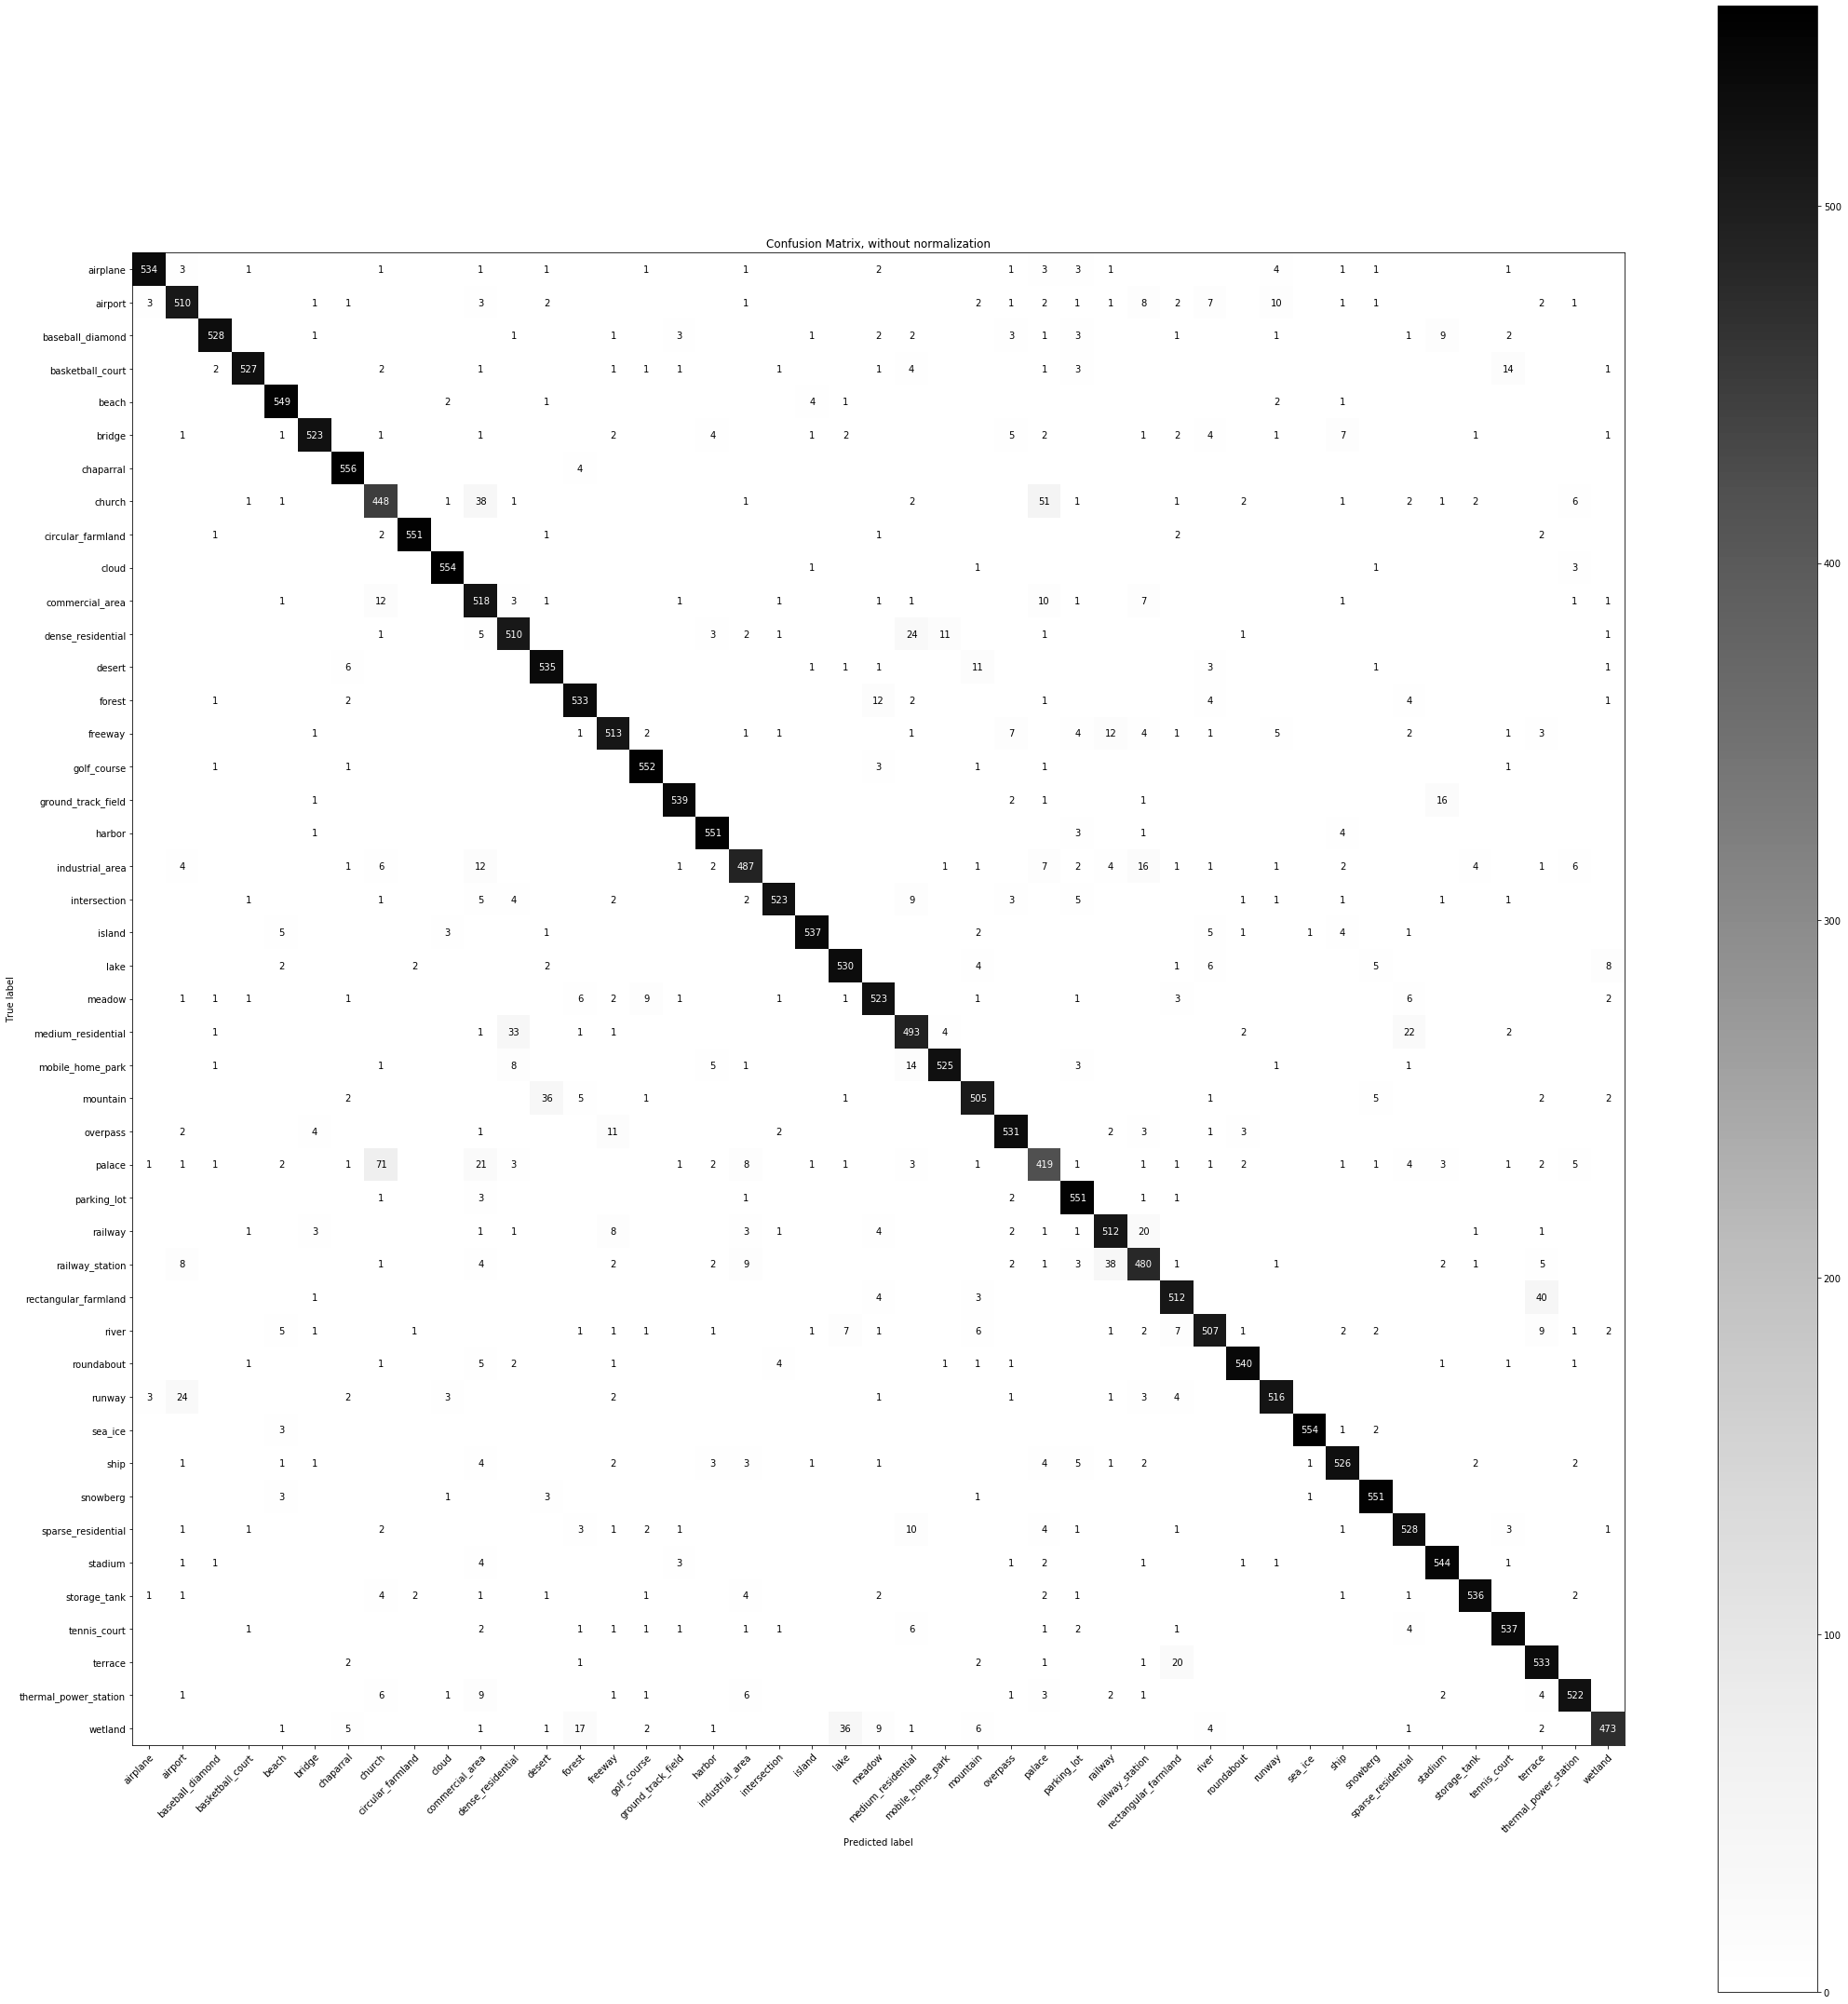

In [23]:
import numpy as np
import pandas as pd
import os
import skimage
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense
import json
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib 

from tensorflow.keras.applications import ResNet50
#  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
from sklearn.utils.multiclass import unique_labels
basepath = input_path + '\Test'
filenames = []
for fname in os.listdir(basepath):
  #  path = os.path.join(basepath, fname)
    filenames.append(fname)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greys):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
   # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
       
    fig, ax = plt.subplots(figsize=(30, 30))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper') 
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.0:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

y_test      = test_generator.classes
y_pred      = y_pred
class_names = test_generator.class_indices

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, 
                      title='Confusion Matrix, without normalization',)

In [24]:
    def overall_accuracy( self ):
        """
        Calculate total accuacy from an error matrix.
        
        This rounds to the same value as shown in Congalton 1991 Table 1
        >>> print congalton_table1().overall_accuracy.round(6)
        73.963134
        """
        return 100.0 * self.astype(float).diagonal().sum() / self.sum().item()
        
    def users_accuracy( self, category ):
        return self.users_accuracies[ category ]
        
    def users_accuracies( self ):
        """
        Return the user's accuracy measures for each category.
        
        Congalton 1991 says, 'if the total number
        of correct pixels in a category is divided by the
        total number of pixels that were classified in that
        category, then this result is a measure of commis-
        sion error. This measure, called "user's accuracy"
        or reliability, is indicative of the probability that a
        pixel classified on the map/image actually repre-
        sents that category on the ground'
        
        The following values match those given in Congalton 1991
        Table 1 (except these values are not rounded to whole numbers)
        >>> congalton_table1().users_accuracies.round(4)
        ErrorMatrix([ 56.5217,  81.    ,  73.913 ,  86.5385])
        """
        u_acc = 100 * self.diagonal().astype(float) / self.sum(axis=1)
        # replace nans with zeros
        if np.isnan( u_acc.sum() ):
            u_acc = np.nan_to_num( u_acc )
        return u_acc
        
    def producers_accuracy( self, category ):
        return self.producers_accuracies[ category ]
        
    def producers_accuracies( self ):
        """
        Return the producer's accuracy measures for each category.
        
        Congalton 1991 says, 'This accuracy measure indicates
        the probability of a reference pixel being correctly 
        classified and is really a measure of omission error.'
        
        The following values match those given in Congalton 1991
        Table 1 (except these values are not rounded to whole numbers)
        >>> congalton_table1().producers_accuracies.round(4)
        ErrorMatrix([ 86.6667,  78.6408,  73.913 ,  63.8298])
        """
        p_acc = 100 * self.diagonal().astype(float) / self.sum(axis=0)
        # if there are nan values we want to convert to zero
        if np.isnan(p_acc.sum()):
            p_acc = np.nan_to_num( p_acc )
        return p_acc

In [25]:
UA = users_accuracies(confusion_matrix(test_generator.classes, y_pred))
PA = producers_accuracies(confusion_matrix(test_generator.classes, y_pred))
max(PA)

99.46140035906643

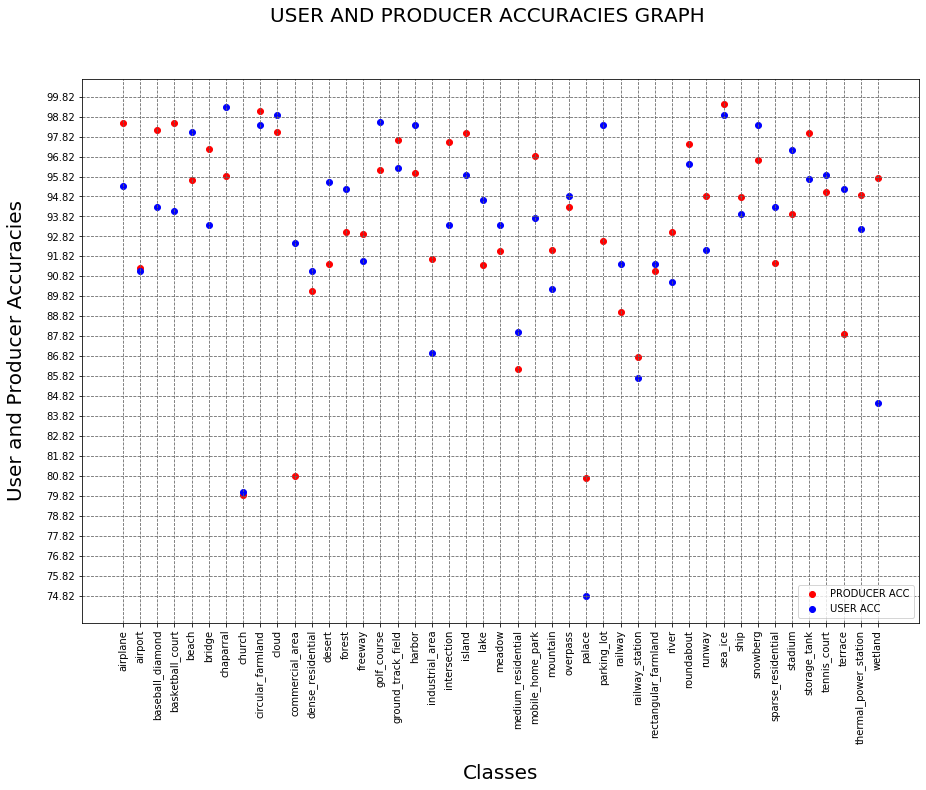

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.suptitle('USER AND PRODUCER ACCURACIES GRAPH',fontsize=20)
plt.scatter(filenames, PA, color="red")
plt.scatter(filenames, UA, color ="blue")
plt.legend(['PRODUCER ACC','USER ACC'],loc='lower right')
MIN = min(UA)
MAX = max(PA)
plt.yticks(np.arange(MIN,100, 1))
plt.xticks(rotation=90)
plt.ylabel('User and Producer Accuracies',fontsize=20, labelpad=20)
plt.xlabel('Classes',fontsize=20, labelpad=20)
plt.grid(b=True, which='major', color='#666666', linestyle='--')
plt.show()

In [27]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [30]:
precs,recalls = [], []

for label in range(45):
    a   = precision(label,cm)
    b = recall(label,cm)
    precs.append(a)
    recalls.append(b)
    
precs
recalls

[0.9535714285714286,
 0.9107142857142857,
 0.9428571428571428,
 0.9410714285714286,
 0.9803571428571428,
 0.9339285714285714,
 0.9928571428571429,
 0.8,
 0.9839285714285714,
 0.9892857142857143,
 0.925,
 0.9107142857142857,
 0.9553571428571429,
 0.9517857142857142,
 0.9160714285714285,
 0.9857142857142858,
 0.9625,
 0.9839285714285714,
 0.8696428571428572,
 0.9339285714285714,
 0.9589285714285715,
 0.9464285714285714,
 0.9339285714285714,
 0.8803571428571428,
 0.9375,
 0.9017857142857143,
 0.9482142857142857,
 0.7482142857142857,
 0.9839285714285714,
 0.9142857142857143,
 0.8571428571428571,
 0.9142857142857143,
 0.9053571428571429,
 0.9642857142857143,
 0.9214285714285714,
 0.9892857142857143,
 0.9392857142857143,
 0.9839285714285714,
 0.9428571428571428,
 0.9714285714285714,
 0.9571428571428572,
 0.9589285714285715,
 0.9517857142857142,
 0.9321428571428572,
 0.8446428571428571]

In [31]:
cm = confusion_matrix(test_generator.classes, y_pred)
print("label precision recall")
for label in range(45):
    print(f"{label+1 :5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    1     0.985  0.954
    2     0.912  0.911
    3     0.981  0.943
    4     0.985  0.941
    5     0.956  0.980
    6     0.972  0.934
    7     0.959  0.993
    8     0.799  0.800
    9     0.991  0.984
   10     0.981  0.989
   11     0.808  0.925
   12     0.901  0.911
   13     0.915  0.955
   14     0.930  0.952
   15     0.929  0.916
   16     0.962  0.986
   17     0.976  0.963
   18     0.960  0.984
   19     0.917  0.870
   20     0.976  0.934
   21     0.980  0.959
   22     0.914  0.946
   23     0.921  0.934
   24     0.862  0.880
   25     0.969  0.938
   26     0.922  0.902
   27     0.943  0.948
   28     0.807  0.748
   29     0.926  0.984
   30     0.890  0.914
   31     0.868  0.857
   32     0.911  0.914
   33     0.930  0.905
   34     0.975  0.964
   35     0.949  0.921
   36     0.995  0.989
   37     0.948  0.939
   38     0.967  0.984
   39     0.915  0.943
   40     0.940  0.971
   41     0.980  0.957
   42     0.950  0.959
   43     0

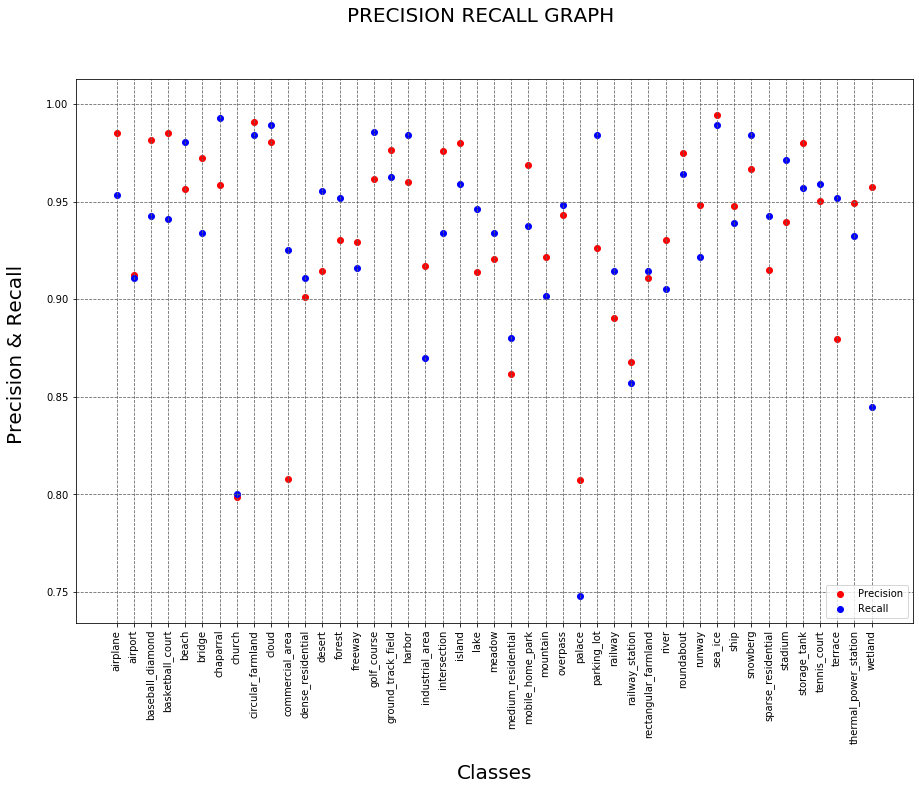

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.suptitle('PRECISION RECALL GRAPH',fontsize=20)
plt.scatter(filenames, precs, color="red")
plt.scatter(filenames, recalls, color ="blue")
plt.legend(['Precision','Recall'],loc='lower right')
#MIN = min(UA)
#MAX = max(PA)
#plt.yticks(np.arange(MIN,100, 1))
plt.xticks(rotation=90)
plt.ylabel('Precision & Recall ',fontsize=20, labelpad=20)
plt.xlabel('Classes',fontsize=20, labelpad=20)
plt.grid(b=True, which='major', color='#666666', linestyle='--')
plt.show()

In [33]:
print("precision total:", precision_macro_average(cm))
precision_total = precision_macro_average(cm)

print("recall total:", recall_macro_average(cm))
recall_total =  recall_macro_average(cm)

precision total: 0.934260110455528
recall total: 0.9335714285714286


In [34]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
F1 = 2 * (precision_total * recall_total)  / ( precision_total + recall_total)
print("F1 score is : ", F1)

##  END